In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt


In [2]:

# 1) --- LOAD AND AGGREGATE EXTERNAL TABLES ------------------------------

def load_and_aggregate():
    # Load raw tables
    bb  = pd.read_csv("data/bureau_balance.csv")
    b   = pd.read_csv("data/bureau.csv")
    pa  = pd.read_csv("data/previous_application.csv")
    pcb = pd.read_csv("data/POS_CASH_balance.csv")
    ccb = pd.read_csv("data/credit_card_balance.csv")
    ip  = pd.read_csv("data/installments_payments.csv")

    # Map bureau_balance statuses to numeric
    status_map = {'C':0, '0':0, 'X':0, '1':1, '2':2, '3':3, '4':4, '5':5}
    bb["STATUS_NUM"] = bb["STATUS"].map(status_map)

    # Aggregate bureau_balance
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(
        MONTHS_COUNT=("MONTHS_BALANCE", "size"),
        WORST_STATUS=("STATUS_NUM",       "max"),
        AVG_STATUS=("STATUS_NUM",         "mean")
    ).reset_index()

    # Merge back to bureau and aggregate per SK_ID_CURR
    b2 = b.merge(bb_agg, on="SK_ID_BUREAU", how="left")
    bureau_agg = b2.groupby("SK_ID_CURR").agg(
        BUREAU_COUNT=("SK_ID_BUREAU",      "size"),
        AVG_CREDIT_SUM=("AMT_CREDIT_SUM",   "mean"),
        MAX_OVERDUE=("CREDIT_DAY_OVERDUE",  "max"),
        BUREAU_WORST_STATUS=("WORST_STATUS","max")
    ).reset_index()

    # Previous applications
    pa_agg = pa.groupby("SK_ID_CURR").agg(
        PREV_COUNT=("SK_ID_PREV",        "size"),
        AVG_PREV_AMT=("AMT_CREDIT",      "mean"),
        REJECTION_RATE=("NAME_CONTRACT_STATUS", lambda s: (s=="Refused").mean())
    ).reset_index()

    # POS cash balance
    pos_agg = pcb.groupby("SK_ID_CURR").agg(
        POS_AVG_BALANCE=("MONTHS_BALANCE","mean"),
        POS_MAX_DPD=("SK_DPD",            "max")
    ).reset_index()

    # Credit card balance
    cc_agg = ccb.groupby("SK_ID_CURR").agg(
        CC_AVG_BALANCE=("AMT_BALANCE",         "mean"),
        CC_UTILIZATION_RATE=("AMT_CREDIT_LIMIT_ACTUAL",
                             lambda x: (x.sum()-x.mean())/x.sum() if x.sum()>0 else 0)
    ).reset_index()

    # Installments payments
    ip["PAY_DIFF"]   = ip["AMT_INSTALMENT"] - ip["AMT_PAYMENT"]
    ip["DELAY_DAYS"] = ip["DAYS_ENTRY_PAYMENT"] - ip["DAYS_INSTALMENT"]
    ip_agg = ip.groupby("SK_ID_CURR").agg(
        INSTL_AVG_PAY_DIFF=("PAY_DIFF",  "mean"),
        INSTL_MAX_DELAY=("DELAY_DAYS",  "max")
    ).reset_index()

    return bureau_agg, pa_agg, pos_agg, cc_agg, ip_agg

# Execute aggregation
bureau_agg, pa_agg, pos_agg, cc_agg, ip_agg = load_and_aggregate()

In [11]:
def merge_main(df):
    df = df.merge(bureau_agg, on="SK_ID_CURR", how="left")
    df = df.merge(pa_agg,     on="SK_ID_CURR", how="left")
    df = df.merge(pos_agg,    on="SK_ID_CURR", how="left")
    df = df.merge(cc_agg,     on="SK_ID_CURR", how="left")
    df = df.merge(ip_agg,     on="SK_ID_CURR", how="left")
    return df

In [12]:
train = merge_main(pd.read_csv("data/application_train.csv"))


In [13]:
train.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_WORST_STATUS,PREV_COUNT,AVG_PREV_AMT,REJECTION_RATE,POS_AVG_BALANCE,POS_MAX_DPD,CC_AVG_BALANCE,CC_UTILIZATION_RATE,INSTL_AVG_PAY_DIFF,INSTL_MAX_DELAY
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,1.0,40455.00,0.00,-5.000000,0.0,NaN,NaN,0.00000,-8.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,1.0,56821.50,0.00,-79.000000,0.0,NaN,NaN,0.00000,3.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,2.0,20625.75,0.00,-79.235294,5.0,NaN,NaN,283.79250,9.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,2.0,134439.75,0.00,-5.550000,0.0,NaN,NaN,0.00000,-8.0
307510,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,0.0,8.0,424431.00,0.25,-16.408451,5.0,NaN,NaN,-6181.50223,7.0


In [14]:
train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [15]:
class_0 = train[train['TARGET'] == 0]
class_1 = train[train['TARGET'] == 1]

# Randomly sample from class 0 equal to the number of class 1
class_0_sampled = class_0.sample(n=len(class_1), random_state=42)

# Combine class 0 sample and all of class 1
df_balanced = pd.concat([class_0_sampled, class_1], axis=0)

# Shuffle the combined dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
df_balanced.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_WORST_STATUS,PREV_COUNT,AVG_PREV_AMT,REJECTION_RATE,POS_AVG_BALANCE,POS_MAX_DPD,CC_AVG_BALANCE,CC_UTILIZATION_RATE,INSTL_AVG_PAY_DIFF,INSTL_MAX_DELAY
49645,250987,0,Cash loans,F,Y,Y,1,202500.0,276277.5,21510.0,...,1.0,1.0,143910.0000,0.000000,-21.000000,0.0,NaN,NaN,0.000000,-7.0
49646,384160,1,Cash loans,F,N,Y,0,135000.0,401386.5,27283.5,...,NaN,6.0,71396.2500,0.333333,-20.969697,28.0,NaN,NaN,886.995000,28.0
49647,290007,1,Cash loans,F,N,N,1,157500.0,450000.0,21888.0,...,NaN,4.0,92995.8750,0.500000,-39.117647,0.0,NaN,NaN,0.000000,-1.0
49648,279059,0,Cash loans,F,N,Y,0,229500.0,444420.0,22819.5,...,0.0,8.0,311653.6875,0.000000,-39.917526,0.0,99358.159402,0.98913,0.000000,0.0
49649,106866,0,Cash loans,F,N,N,0,225000.0,900000.0,32458.5,...,1.0,2.0,121403.2500,0.000000,-67.000000,5.0,NaN,NaN,4215.100781,28.0


In [17]:
nan_rows = df_balanced[df_balanced.isnull().any(axis=1)]
print("Number of rows with NaN values:", len(nan_rows))

Number of rows with NaN values: 49482


In [18]:
# feature Type detection
numeric_cols = df_balanced.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols     = df_balanced.select_dtypes(include=["object"]).columns.tolist()

In [19]:
for i in cat_cols:
    print(i)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE


In [20]:
for i in cat_cols:
    print(i)
    print(df_balanced[i].unique())
    print()

NAME_CONTRACT_TYPE
['Cash loans' 'Revolving loans']

CODE_GENDER
['M' 'F' 'XNA']

FLAG_OWN_CAR
['N' 'Y']

FLAG_OWN_REALTY
['Y' 'N']

NAME_TYPE_SUITE
['Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B' nan
 'Other_A' 'Group of people']

NAME_INCOME_TYPE
['Pensioner' 'Working' 'State servant' 'Commercial associate' 'Unemployed'
 'Student' 'Maternity leave' 'Businessman']

NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

NAME_FAMILY_STATUS
['Married' 'Widow' 'Civil marriage' 'Single / not married' 'Separated']

NAME_HOUSING_TYPE
['House / apartment' 'With parents' 'Rented apartment' 'Office apartment'
 'Municipal apartment' 'Co-op apartment']

OCCUPATION_TYPE
[nan 'Laborers' 'Core staff' 'Accountants' 'High skill tech staff'
 'Cooking staff' 'Managers' 'Sales staff' 'Low-skill Laborers'
 'Security staff' 'Medicine staff' 'Drivers' 'Cleaning staff'
 'Waiters/barmen staff' 'Realty agents' 'Secreta

In [21]:
def ordinal_to_num(df):
    ordinal_cols=["NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS"]
    education_order = [
        'Lower secondary',
        'Secondary / secondary special',
        'Incomplete higher',
        'Higher education',
        'Academic degree'
    ]

    family_status_order = [
        'Unknown',
        'Separated',
        'Widow',
        'Single / not married',
        'Civil marriage',
        'Married'
    ]
    df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].fillna("Lower secondary")
    df["NAME_FAMILY_STATUS"] = df["NAME_FAMILY_STATUS"].fillna("Unknown")
    encoder = OrdinalEncoder(categories=[education_order, family_status_order])
    df[['EDUCATION_ORD', 'FAMILY_STATUS_ORD']] = encoder.fit_transform(df[["NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS"]])
    return df
df_balanced=ordinal_to_num(df_balanced)



In [22]:
cat_cols.remove("NAME_EDUCATION_TYPE")
cat_cols.remove("NAME_FAMILY_STATUS")
len(cat_cols)

14

In [23]:
for col in cat_cols:
    df_balanced[col] = df_balanced[col].astype(str)  # Convert NaNs to 'nan'
    le = LabelEncoder()
    df_balanced[col] = le.fit_transform(df_balanced[col])

In [24]:
# drop non numerical cols
df = df_balanced.select_dtypes(include=['number'])
df= df.drop(columns='SK_ID_CURR')

In [25]:
df.tail()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AVG_PREV_AMT,REJECTION_RATE,POS_AVG_BALANCE,POS_MAX_DPD,CC_AVG_BALANCE,CC_UTILIZATION_RATE,INSTL_AVG_PAY_DIFF,INSTL_MAX_DELAY,EDUCATION_ORD,FAMILY_STATUS_ORD
49645,0,0,0,1,1,1,202500.0,276277.5,21510.0,238500.0,...,143910.0000,0.000000,-21.000000,0.0,NaN,NaN,0.000000,-7.0,1.0,5.0
49646,1,0,0,0,1,0,135000.0,401386.5,27283.5,346500.0,...,71396.2500,0.333333,-20.969697,28.0,NaN,NaN,886.995000,28.0,1.0,3.0
49647,1,0,0,0,0,1,157500.0,450000.0,21888.0,450000.0,...,92995.8750,0.500000,-39.117647,0.0,NaN,NaN,0.000000,-1.0,2.0,4.0
49648,0,0,0,0,1,0,229500.0,444420.0,22819.5,337500.0,...,311653.6875,0.000000,-39.917526,0.0,99358.159402,0.98913,0.000000,0.0,1.0,4.0
49649,0,0,0,0,0,0,225000.0,900000.0,32458.5,900000.0,...,121403.2500,0.000000,-67.000000,5.0,NaN,NaN,4215.100781,28.0,1.0,1.0


In [26]:
df = df.fillna(df.mean(numeric_only=True))


In [27]:
df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
df["ANNUITY_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
df["CREDIT_INCOME_RATIO"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
df["EMPLOYED_TO_BIRTH_RATIO"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
df["EXT_SOURCES_MEAN"] = df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)

C:\Users\alire\AppData\Local\Temp\ipykernel_4272\344513692.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
C:\Users\alire\AppData\Local\Temp\ipykernel_4272\344513692.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ANNUITY_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
C:\Users\alire\AppData\Local\Temp\ipykernel_4272\344513692.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

In [28]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_UTILIZATION_RATE,INSTL_AVG_PAY_DIFF,INSTL_MAX_DELAY,EDUCATION_ORD,FAMILY_STATUS_ORD,INCOME_PER_PERSON,ANNUITY_INCOME_RATIO,CREDIT_INCOME_RATIO,EMPLOYED_TO_BIRTH_RATIO,EXT_SOURCES_MEAN
0,0,0,1,0,1,0,90000.0,454500.0,25375.5,454500.0,...,0.907055,2604.510000,10.0,1.0,5.0,45000.0,0.281950,5.050000,-16.549298,0.648686
1,0,0,0,0,0,0,72000.0,296280.0,16069.5,225000.0,...,0.907055,0.000000,-3.0,1.0,2.0,72000.0,0.223188,4.115000,0.031444,0.540345
2,0,0,0,0,0,0,99000.0,284400.0,18643.5,225000.0,...,0.907055,0.000000,-8.0,1.0,4.0,49500.0,0.188318,2.872727,0.098970,0.387990
3,0,0,0,0,1,0,112500.0,308133.0,16843.5,234000.0,...,0.888889,-3579.809400,0.0,3.0,5.0,56250.0,0.149720,2.738960,0.461196,0.461490
4,0,0,0,1,1,0,450000.0,503266.5,57046.5,463500.0,...,0.954545,3191.012069,13.0,1.0,3.0,450000.0,0.126770,1.118370,0.014195,0.518515


In [29]:
# correlation matrix
corr=df.corr()

In [30]:
target_corr = corr['TARGET'].sort_values(ascending=False)
top_features = target_corr.abs().sort_values(ascending=False)
top=top_features.head(15)
print("\nTop Features Correlated with Target:")
print(top)


Top Features Correlated with Target:
TARGET                         1.000000
EXT_SOURCES_MEAN               0.381649
EXT_SOURCE_3                   0.276761
EXT_SOURCE_2                   0.270473
EXT_SOURCE_1                   0.190461
DAYS_BIRTH                     0.139238
REJECTION_RATE                 0.121661
EDUCATION_ORD                  0.113007
REGION_RATING_CLIENT_W_CITY    0.108489
DAYS_LAST_PHONE_CHANGE         0.102877
REGION_RATING_CLIENT           0.102847
CODE_GENDER                    0.098219
DAYS_ID_PUBLISH                0.092278
NAME_INCOME_TYPE               0.091121
FLAG_EMP_PHONE                 0.089946
Name: TARGET, dtype: float64


In [31]:
top.index

Index(['TARGET', 'EXT_SOURCES_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
       'EXT_SOURCE_1', 'DAYS_BIRTH', 'REJECTION_RATE', 'EDUCATION_ORD',
       'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE',
       'REGION_RATING_CLIENT', 'CODE_GENDER', 'DAYS_ID_PUBLISH',
       'NAME_INCOME_TYPE', 'FLAG_EMP_PHONE'],
      dtype='object')

In [32]:
df_train=df[top.index]
df_train.head()

,TARGET,EXT_SOURCES_MEAN,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,REJECTION_RATE,EDUCATION_ORD,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,REGION_RATING_CLIENT,CODE_GENDER,DAYS_ID_PUBLISH,NAME_INCOME_TYPE,FLAG_EMP_PHONE
0,0,0.648686,0.753067,0.739880,0.453112,-22070,0.000000,1.0,2,-931.0,2,1,-4078,3,0
1,0,0.540345,0.457038,0.710884,0.453112,-18732,0.000000,1.0,2,-939.0,2,0,-2268,7,1
2,0,0.387990,0.235311,0.586182,0.342477,-11559,0.500000,1.0,2,-2170.0,2,0,-2218,7,1
3,0,0.461490,0.457038,0.474319,0.453112,-12821,0.000000,3.0,2,-300.0,2,0,-639,4,1
4,0,0.518515,0.723837,0.528323,0.303385,-12117,0.333333,1.0,2,-744.0,2,0,-491,1,1


In [33]:
df_train['TARGET'].value_counts()


TARGET
0    24825
1    24825
Name: count, dtype: int64

In [34]:
# split features and target
X=df_train.drop(columns=["TARGET"])
Y=df_train['TARGET']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

Accuracy:  0.6637462235649547
[[3310 1706]
 [1633 3281]]
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      5016
           1       0.66      0.67      0.66      4914

    accuracy                           0.66      9930
   macro avg       0.66      0.66      0.66      9930
weighted avg       0.66      0.66      0.66      9930


Validation Metrics:
Accuracy: 0.6637
Precision: 0.6579
Recall: 0.6677
F1 Score: 0.6628


<Figure size 800x600 with 0 Axes>

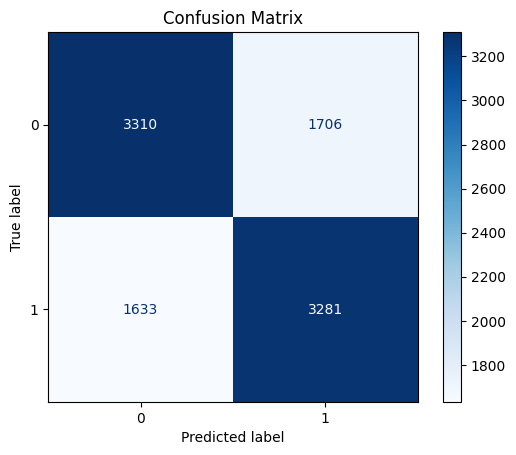

In [36]:
model_DTC = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=5,                 # Limit depth to avoid overfitting
    min_samples_leaf=10,         # Minimum samples required in each leaf
    random_state=42
)
model_DTC.fit(X_train,y_train)
y_pred= model_DTC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ",accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValidation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
#plt.savefig("results/confusion_matrix.png")
plt.show()




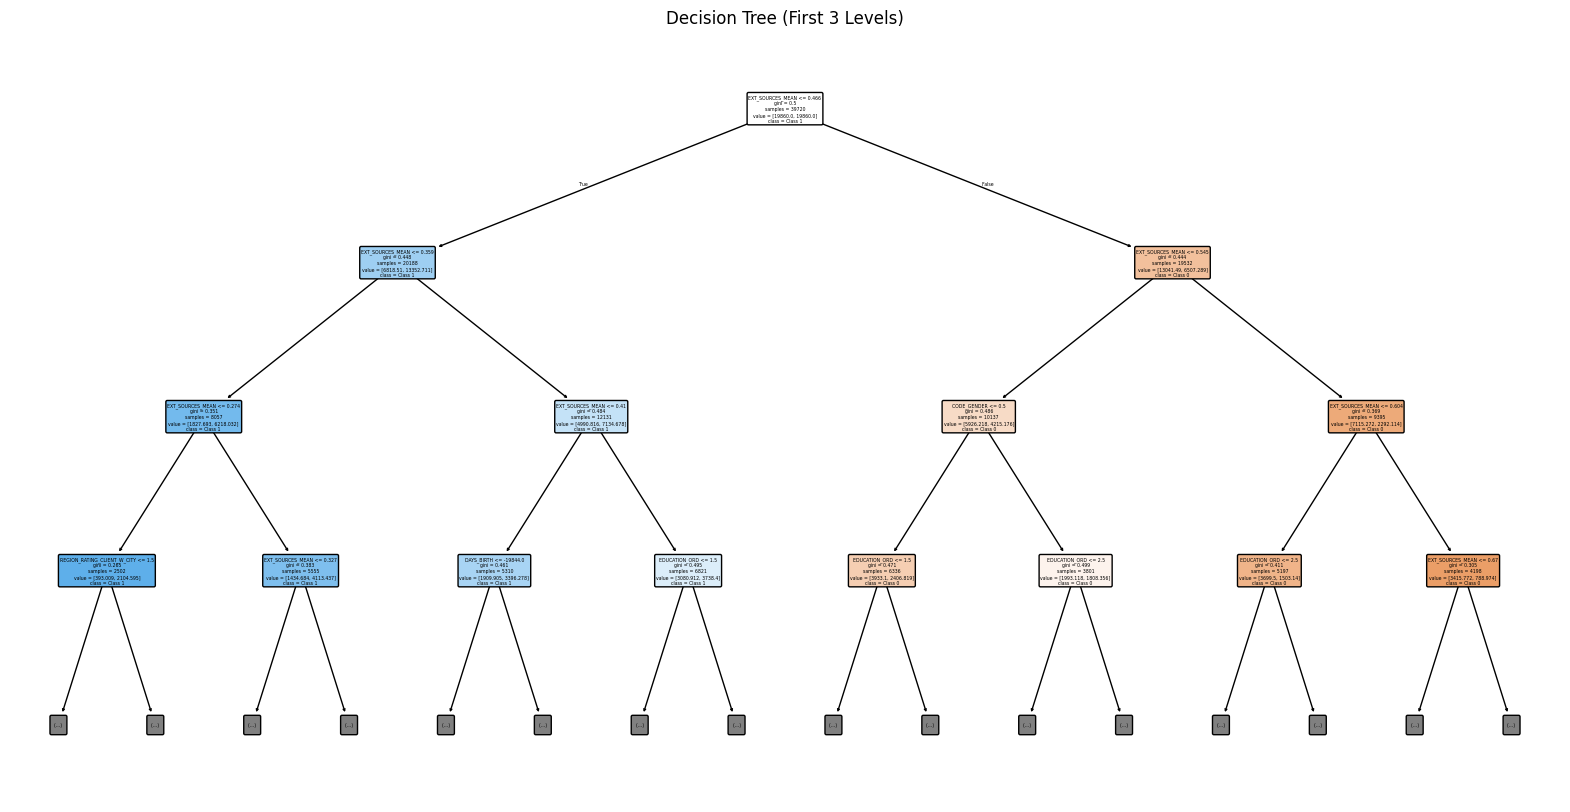

In [37]:
plt.figure(figsize=(20,10))
plot_tree(model_DTC, 
          feature_names=X.columns, 
          class_names=["Class 0", "Class 1"],  # Update based on your data
          filled=True, 
          rounded=True, 
          max_depth=3)  # Limit depth for readability
plt.title("Decision Tree (First 3 Levels)")
plt.show()

In [ ]:
# # save model
# import joblib
# joblib.dump(model_DTC, "loan_default_model_DTC.pkl")

['loan_default_model_DTC.pkl']

Accuracy:  0.6651560926485398
[[3402 1614]
 [1711 3203]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      5016
           1       0.66      0.65      0.66      4914

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930


Validation Metrics:
Accuracy: 0.6652
Precision: 0.6649
Recall: 0.6518
F1 Score: 0.6583


<Figure size 800x600 with 0 Axes>

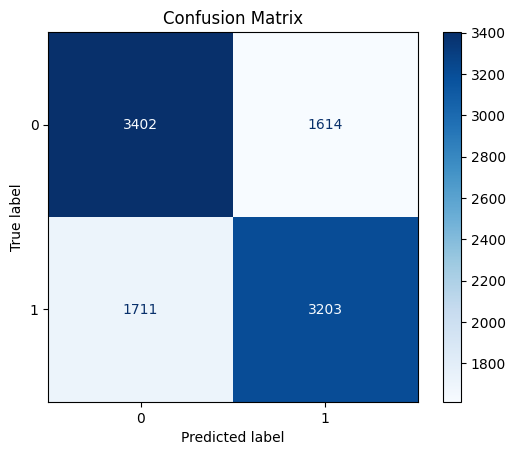

In [38]:
model_rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,                 # Prevent overly complex trees
    min_samples_leaf=10,
    n_estimators=100,
    random_state=42
)
model_rf.fit(X_train,y_train)
y_pred_rf= model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: ",accuracy)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print("\nValidation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap="Blues")
plt.title("Confusion Matrix")
#plt.savefig("results/confusion_matrix.png")
plt.show()

